Code to reproduce plots from: https://www.sciencedirect.com/science/article/pii/S1465324921007453 

In [2]:
fn = '/Users/admin/HLA/RUNS_haplomat/1835/frequencies.dat'

In [3]:
def haplomat_output_parce(hfs_dat, n):
    
    with open(hfs_dat) as f:
        cretan_haplotypes = [x.replace('\n', '').replace('g', '').split() for x in f.readlines()]

    cretan_haplotypes = [( '-'.join(sorted(x[0].split('~'))  ), float(x[1])) for x in cretan_haplotypes]

    cretan_haplotypes = {x[0]:x[1] for x in cretan_haplotypes}
    cretan_haplotypes = {k:v for k,v in cretan_haplotypes.items() if v >= 1/(2*n)}
    
    return cretan_haplotypes

In [14]:
### After we run the Hapl-o-Mat with the g grouping without missing data we calculate the allele frequencies

def af_estimation_from_HaploMat_g_group(hfs_dat, hla_gene, num_of_people, alleles=None, counts=None):
    
    '''
    !!!README!!!
    
    This function calculates the allele frequency of the HLA genes A, B, C, DRB1, DQB1 and DPB1 
    if the haplotypes have them. 
    
    Hapl-o-Mat orders the genes in the haplotypes alphabetically.
    
    The haplotypes with 4 genes should have the HLA genes below in this order only:
    A~B~C~DRB1
    
    The haplotypes with 5 genes should have the HLA genes below in this order only:
    A~B~C~DQB1~DRB1
    
    The haplotypes with 6 genes should have the HLA genes below in this order only:
    A~B~C~DPB1~DQB1~DRB1
    
    Other combinations of the HLA genes can not be used as input.    
    
    This function returns the estimated allele frequencies/counts and alleles of the sample from Hapl-o-Mat.
    '''
    
    if hla_gene not in ('A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1'):
        raise Exception("The hla_gene can only be 'A', 'B', 'C', 'DRB1', 'DQB1' or 'DPB1'")
        
    if counts and alleles:
        raise Exception('Only 1 output can come from this function.')
    
    with open(hfs_dat, 'r') as f:
        f = f.readlines()
        
    f = [x.strip('\n').split('\t') for x in f]
    allele_freq = [(x[0].split('~'), float(x[1])) for x in f]
    allele_freq = [([y.strip('g') for y in x[0]],x[1]) for x in allele_freq]
    
    if hla_gene == 'A':
        n = 0        
    elif hla_gene == 'B':
        n = 1        
    elif hla_gene == 'C':
        n = 2        
    
    elif hla_gene == 'DRB1': # Hapl-o-Mat orders the genes in the haplotypes alphabetically.
        if len(allele_freq[0][0]) == 4:     
            n = 3
        elif len(allele_freq[0][0]) == 5:     
            n = 4    
        elif len(allele_freq[0][0]) == 6:
            n = 5
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')
    
    elif hla_gene == 'DQB1':
        if len(allele_freq[0][0]) == 4:     
            raise Exception('DQB1 should not be in a haplotype with only 4 genes. Read the documentation.')
        elif len(allele_freq[0][0]) == 5:     
            n = 3    
        elif len(allele_freq[0][0]) == 6:
            n = 4
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')                 
    
    elif hla_gene == 'DPB1':
        if len(allele_freq[0][0]) == 4:     
            raise Exception('DPB1 should not be in a haplotype with only 4 genes. Read the documentation.')
        elif len(allele_freq[0][0]) == 5:     
            raise Exception('DPB1 should not be in a haplotype with only 5 genes. Read the documentation.')    
        elif len(allele_freq[0][0]) == 6:
            n = 3
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')
    
    HLA_gene = {el:0 for el in [x[0][n] for x in allele_freq]}
    
    for x in allele_freq:
        HLA_gene[x[0][n]] += x[1]
    
    HLA_gene = {k:v for k, v in sorted(HLA_gene.items(), key=lambda item: item[1], reverse=True)}
    
    if alleles:
        return list(HLA_gene.keys())
    
    elif counts:        
        return {k:round(v*num_of_people) for k,v in HLA_gene.items()} 
        # No need to multiply by 2, because of the 2 genotypes on MAC input
    
    else:
        return HLA_gene

In [16]:
def chi2(gene_final_cretan_study, gene_final_freqnet, common_alleles, people_in_study, population, sig_afs=None, counts=None):
    
    if not len(gene_final_cretan_study) == len(gene_final_freqnet) == len(common_alleles):
        raise Exception('Not the same length of common genes')
    
    gene = common_alleles[0].split('*')[0]
    
    cretan_counts = [x*people_in_study*2 for x in gene_final_cretan_study]
    cretan_counts = [np.round(x) for x in cretan_counts]

    af_pop = population['pop'].to_list()[0]
    freqnet_num = population['sample_size'].to_list()[0]   
    
    pop_counts = [x*freqnet_num*2 for x in gene_final_freqnet]
    
    comparison_list = [list(a) for a in zip(cretan_counts, pop_counts)]
    
    if counts:   
        obs = []
        for x in range(len(comparison_list)):
            obs.append(np.round(np.array([comparison_list[x], [people_in_study*2-comparison_list[x][0],freqnet_num*2-comparison_list[x][1]]])))
        
        obs = [np.flip(obs[x], 0).T for x in range(len(obs))]
        
        return obs
    
    comparison_list_af = [list(a) for a in zip(gene_final_cretan_study, gene_final_freqnet)]
        
    pvalues = []

    for x in range(len(comparison_list)):
        obs = np.round(np.array([comparison_list[x], [people_in_study*2-comparison_list[x][0],freqnet_num*2-comparison_list[x][1]]]))
        chi2, p, df, exp = chi2_contingency(obs)
        pvalues.append(p)

    pval_dict = dict(zip(common_alleles, pvalues))

    wanted_alleles = {k:v for k,v in pval_dict.items() if v<0.05}

    initial_dict = dict(zip(common_alleles, zip(gene_final_cretan_study, gene_final_freqnet)))
    significant_dict = {k:v for z,w in wanted_alleles.items() for k,v in initial_dict.items() if z in k}

    if sig_afs:            
        significant_dict = {k:v for k,v in significant_dict.items() if v[0] > round(1/(2*people_in_study), 6) and v[1] > round(1/(2*freqnet_num), 4)}

    common_alleles_sig = list(significant_dict.keys())
    gene_final_cretan_study_sig = [x[0] for x in significant_dict.values()]
    gene_final_freqnet_sig = [x[1] for x in significant_dict.values()]

    return gene_final_cretan_study_sig, gene_final_freqnet_sig, common_alleles_sig 

In [17]:
def get_common_g_alleles(cretans, population, HLA_gene):
    
    alleles_allelefreq_net = population[population['gene']==HLA_gene]['allele'].tolist()  
    common_alleles = list(set(alleles_allelefreq_net).intersection(list(cretans.keys())))
    
    alleles_freqnet = dict(zip(population[population['gene']==HLA_gene].sort_values('af', ascending=False)['allele'].tolist(), population[population['gene']==HLA_gene].sort_values('af', ascending=False)['af'].tolist()))

    alleles_final_Cretans = []

    for x in common_alleles:
        alleles_final_Cretans.append(cretans[x])

    tmp_hla_alleles_Cretans = dict(zip(common_alleles, alleles_final_Cretans))
    tmp_hla_alleles_Cretans = {k: v for k, v in sorted(tmp_hla_alleles_Cretans.items(), key=lambda item: item[1], reverse=True)}

    tmp_alleles_freqnet = {}

    for x in tmp_hla_alleles_Cretans.keys():
        tmp_alleles_freqnet[x] = alleles_freqnet[x]

    common_alleles = list(tmp_hla_alleles_Cretans.keys())
    alleles_final_freqnet = list(tmp_alleles_freqnet.values())
    alleles_final_Cretans = list(tmp_hla_alleles_Cretans.values())
    
    return alleles_final_Cretans, alleles_final_freqnet, common_alleles

In [13]:
_ = haplomat_output_parce(fn, 1835)

In [11]:
_ = af_estimation_from_HaploMat_g_group(fn, 'A', 1835)

In [19]:
A_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g4_path, 'A', 1835)
B_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g4_path, 'B', 1835)
C_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g4_path, 'C', 1835)
DRB1_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g4_path, 'DRB1', 1835)
DQB1_g_grouped_1835_Cretans = af_estimation_from_HaploMat_g_group(g5_path, 'DQB1', 1835)

NameError: name 'g4_path' is not defined

In [18]:
# ### Let's compare the HLA allelic frequencies of all minorities in Germany with the 1835 Cretans ###

A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, DKMS_all_final, 'A')
B_final_1835_DKMSALL_GER, B_final_freqnet_1835_DKMSALL_GER, common_B_1835_DKMSALL_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, DKMS_all_final, 'B')
C_final_1835_DKMSALL_GER, C_final_freqnet_1835_DKMSALL_GER, common_C_1835_DKMSALL_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, DKMS_all_final, 'C')
DRB1_final_1835_DKMSALL_GER, DRB1_final_freqnet_1835_DKMSALL_GER, common_DRB1_1835_DKMSALL_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, DKMS_all_final, 'DRB1')

# ### Let's compare the HLA allelic frequencies of all minorities without the Greeks in Germany with the 1835 Cretans ###

A_final_1835_DKMSNOGR_GER, A_final_freqnet_1835_DKMSNOGR_GER, common_A_1835_DKMSNOGR_GER = get_common_g_alleles(A_g_grouped_1835_Cretans, DKMS_final, 'A')
B_final_1835_DKMSNOGR_GER, B_final_freqnet_1835_DKMSNOGR_GER, common_B_1835_DKMSNOGR_GER = get_common_g_alleles(B_g_grouped_1835_Cretans, DKMS_final, 'B')
C_final_1835_DKMSNOGR_GER, C_final_freqnet_1835_DKMSNOGR_GER, common_C_1835_DKMSNOGR_GER = get_common_g_alleles(C_g_grouped_1835_Cretans, DKMS_final, 'C')
DRB1_final_1835_DKMSNOGR_GER, DRB1_final_freqnet_1835_DKMSNOGR_GER, common_DRB1_1835_DKMSNOGR_GER = get_common_g_alleles(DRB1_g_grouped_1835_Cretans, DKMS_final, 'DRB1')

NameError: name 'A_g_grouped_1835_Cretans' is not defined

In [ ]:
e,f,g=chi2(A_final_1835_DKMSALL_GER, A_final_freqnet_1835_DKMSALL_GER, common_A_1835_DKMSALL_GER, 1835, DKMS_all_final, sig_afs=True)

In [12]:
def get_comparison_diagram(gene_final_cretan_study, gene_final_freqnet, common_alleles, people_in_study, population, sig_af=None, sig_p=None):

    if not len(gene_final_cretan_study) == len(gene_final_freqnet) == len(common_alleles):
        raise Exception('Not the same length of common genes')
    
    af_pop = population['pop'].to_list()[0]
    freqnet_num = population['sample_size'].to_list()[0]
    
    if sig_af and not sig_p:
        tmp = dict(zip(common_alleles, zip(gene_final_cretan_study, gene_final_freqnet)))
        tmp = {k:v for k,v in tmp.items() if v[0] > round(1/(2*people_in_study), 6) and v[1] > round(1/(2*freqnet_num), 4)}
        
        gene_final_cretan_study = [v[0] for k,v in tmp.items()]
        gene_final_freqnet = [v[1] for k,v in tmp.items()]
        common_alleles = list(tmp.keys()) 
        
    common_alleles_num = len(common_alleles)
    gene = common_alleles[0].split('*')[0]
    index = np.arange(common_alleles_num) 
    bar_width = 0.35
    
    fig, ax = plt.subplots()

    if people_in_study == 94:
        Cretans_94 = ax.bar(index, gene_final_cretan_study, bar_width, label="94 Cretans", color = 'orange')

    if 675 < people_in_study < 690:    
        Cretans_689 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'green')
     
    if 1100 < people_in_study < 1215:    
        Cretans_1204 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'red')
    
    if 1700 < people_in_study < 2001:    
#         Cretans_1835 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'goldenrod')
        Cretans_1835 = ax.bar(index, gene_final_cretan_study, bar_width, label=f"{people_in_study} Cretans", color = 'dimgrey')
    
#     freq_net = ax.bar(index+bar_width, gene_final_freqnet, bar_width, label=f"{freqnet_num} {af_pop}", color = 'blue')
    freq_net = ax.bar(index+bar_width, gene_final_freqnet, bar_width, label=f"{freqnet_num} {af_pop}", color = 'darkgrey')

    ax.set_ylabel('Allele Frequency', fontsize=13)
    
#     if sig_p and not sig_af:
#         ax.set_title(f'Comparison of HLA-{gene} frequencies with p < 0.05', fontsize=15)
#     elif sig_af and not sig_p:
#         ax.set_title(f'Comparison of HLA-{gene} frequencies with af > 1/2n', fontsize=15)
#     elif sig_af and sig_p:
#         ax.set_title(f'Comparison of HLA-{gene} frequencies with p < 0.05 and af > 1/2n', fontsize=11)
#     else:
#         ax.set_title(f'Comparison of HLA-{gene} frequencies', fontsize=15)
        
    ax.set_xticks(index + bar_width / 2)
    
    if gene == 'B':
        font = 7
    else:
        font = 11
        
    ax.set_xticklabels(common_alleles, rotation=90, fontsize=font)
    ax.legend()
    
#     fig.tight_layout()    
#     fig.set_dpi(300)
    
#     if sig_p and not sig_af:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_significant_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_significant_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png")
#     elif sig_af and not sig_p:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_with_af_greater_than_1_to_2n.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_with_af_greater_than_1_to_2n.png")
#     elif sig_af and sig_p:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_significant_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_with_af_greater_than_1_to_2n.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_significant_HLA-{gene}_frequencies_{people_in_study}_{af_pop}_with_af_greater_than_1_to_2n.png")
#     else:
#         if af_pop == 'DKMS with Greeks' or af_pop == 'DKMS without Greeks':      
#             plt.savefig(f'{af_pop}_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png')
#         else:
#             plt.savefig(f"{af_pop.split(' ')[3]}_in_Germany_comparison_{people_in_study}_freqnet/HLA-{gene}/Comparison_of_HLA-{gene}_frequencies_{people_in_study}_{af_pop}.png")
    
    plt.show()

In [ ]:
get_comparison_diagram(e,f,g,1835, DKMS_all_final, sig_p=True, sig_af=True)

In [ ]:
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################
###########################################################################################################################

In [262]:
from collections import Counter, defaultdict
import pandas as pd
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
import os, itertools, csv, scipy.stats, re, random, copy
from itertools import combinations, chain, groupby, islice
from collections import Counter
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency, norm
#from iteround import saferound
from statsmodels.stats.proportion import proportion_confint
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [112]:
###############################################################
##      Calculates the frequency of each allele              ##
###############################################################
def allele_freq(pop_txt, #txt file=> columns = [A,A,,B,B...], rows = [01:01,02:01,....]
                classII=None, #classII = [DRB1,DQB1,DPB1]
               ):
    
    '''
    The Cretan  HLA profile should include all the HLA genes (A,B,C,DRB1,DQB1,DPB1). 
    So we keep all the individuals (1835) who are fully genotyped on these 6 HLA genes.
    '''
    
    with open('/Users/vasou/Downloads/'+pop_txt, 'r') as f:
        af = f.readlines()
        
    results = defaultdict()
    af = [x.strip('\n').split('\t') for x in af]
    num_people=len(af)
    
    alleles = {'A':[1,2], #allele:indexes on x(for x in af)
               'B':[3,4],
               'C':[5,6],
               'DRB1':[7,8],
               'DQB1':[9,10],
               'DPB1':[11,12],
              }

    for key in alleles:
        results[f'N_{key}'] = dict(Counter([x[alleles[key][0]] for x in af[1:]] + [x[alleles[key][1]] for x in af[1:]]))
        results[f'N_{key}'] = {k:v for k,v in sorted(results[f'N_{key}'].items(), key=lambda item:item[1], reverse = True)}
        results[f'AF_{key}'] = {k:v/(2*num_people) for k,v in results[f'N_{key}'].items()}
        results[f'{key}'] = [f'{key}*'+x for x in list(results[f'N_{key}'].keys())]
    
    if not classII:   
        keys = ['A', 'N_A', 'AF_A', 'B', 'N_B', 'AF_B', 'C', 'N_C', 'AF_C']
        nest = [results[key].values() if '_' in key else results[key] for key in keys]
        target_class = pd.DataFrame((_ for _ in itertools.zip_longest(*nest,fillvalue = '0')), columns=keys)
        target_class[['N_A','N_B','N_C']] =  target_class[['N_A','N_B','N_C']].astype(int)
        return target_class
    else:
        keys = ['DRB1', 'N_DRB1', 'AF_DRB1', 'DQB1', 'N_DQB1', 'AF_DQB1', 'DPB1', 'N_DPB1', 'AF_DPB1']
        nest = [results[key].values() if '_' in key else results[key] for key in keys]
        target_class = pd.DataFrame((_ for _ in itertools.zip_longest(*nest,fillvalue = '0')), columns=keys)
        target_class[['N_DRB1','N_DQB1','N_DPB1']] =  target_class[['N_DRB1','N_DQB1','N_DPB1']].astype(int)
        return target_class


classI = allele_freq('pop.txt', classII=False).head(10)
classII = allele_freq('pop.txt', classII=True).head(10)

In [192]:
####################################################################################
##       Create dict: key = ID, value = dict(nomos:chania, A:01:01,B....)         ##
####################################################################################
def get_cretan_population(excel_file,#data with necessary columns: ID, REGIONAL UNIT OF DESCENT 2ND GENERATION_75%, alleles
                          sheet_name = None,#read sheets
                          Crete_75=None, #take the samples that the 75% belongs to crete 
                          Crete_50_and_75=None,
                          municipality_75=None,
                          municipality_50_and_75=None):
    
    if sum(x for x in [Crete_75, Crete_50_and_75, municipality_75, municipality_50_and_75] if x) > 1:
        raise Exception('Only 1 value must be True.')

    if sheet_name:
        df = pd.read_excel(excel_file, sheet_name=sheet_name)
    else:
        df = pd.read_excel(excel_file)
    df.fillna('', inplace=True)  
    print(f'The number of unique samples in {excel_file}: {len(pd.unique(df["ID"]))}')

    targets = ['REGIONAL UNIT OF DESCENT 2ND GENERATION_75%',\
             'A','B','C',\
             'DRB1','DQB1','DPB1']

    data = defaultdict(lambda:defaultdict())
    
    for row in df.iterrows():
        for target in targets:
            if target in ['REGIONAL UNIT OF DESCENT 2ND GENERATION_75%']:
                data[row[1]['ID']][target] = row[1]['REGIONAL UNIT OF DESCENT 2ND GENERATION_75%']
            else:
                data[row[1]['ID']][target] = (row[1][target+'1'], row[1][target+'2']) \
                if 'D' not in target else (row[1][target+'_1'], row[1][target+'_2'])
                
    if Crete_50_and_75:
        return data
    
    elif Crete_75:
        return {k:v for k,v in data.items() if not any(
                x in v['REGIONAL UNIT OF DESCENT 2ND GENERATION_75%']  
                for x in ['','not found','ABROAD']
                )
               }
    
    elif municipality_50_and_75: #pali ta abroad vgazei?
        return {k:v for k,v in data.items() if v['REGIONAL UNIT OF DESCENT 2ND GENERATION_75%'] not in (
           '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΡΕΘΥΜΝΟΥ',
           '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΛΑΣΙΘΙΟΥ & 25% ΗΡΑΚΛΕΙΟΥ',
           '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΡΕΘΥΜΝΟΥ & 25% ΗΡΑΚΛΕΙΟΥ',
           '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΡΕΘΥΜΝΟΥ & 25% ΛΑΣΙΘΙΟΥ',
           '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΗΡΑΚΛΕΙΟΥ',
           '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΛΑΣΙΘΙΟΥ', 
           '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΧΑΝΙΩΝ & 25% ΡΕΘΥΜΝΟΥ',
           '25% ΧΑΝΙΩΝ & 25% ΛΑΣΙΘΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ',
           '25% ΡΕΘΥΜΝΟΥ & 25% ΗΡΑΚΛΕΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ',
           '50% ΕΚΤΟΣ ΚΡΗΤΗΣ/25% ΗΡΑΚΛΕΙΟΥ & 25% ΑΝΩΓΕΙΩΝ',
           '25% ΡΕΘΥΜΝΟΥ & 25% ΛΑΣΙΘΙΟΥ/50% ΕΚΤΟΣ ΚΡΗΤΗΣ')}
    
    elif municipality_75:                
        return {k:v for k,v in data.items() if v['REGIONAL UNIT OF DESCENT 2ND GENERATION_75%'] in ('ΗΡΑΚΛΕΙΟΥ', 'ΛΑΣΙΘΙΟΥ', 'ΡΕΘΥΜΝΟΥ', 'ΧΑΝΙΩΝ')}

Crete_50_and_75 = get_cretan_population('Crete_428CBUs_120723.xlsx', Crete_50_and_75=True)
Crete_75 = get_cretan_population('Crete_428CBUs_120723.xlsx', Crete_75=True)
#municipality_50_and_75 = get_cretan_population('final samples_prefecture analyses_111120.xlsx',  '1926_excl_relations', municipality_50_and_75=True)
municipality_75 = get_cretan_population('Crete_428CBUs_120723.xlsx', municipality_75=True)#n_Cretans = len(Crete_75)
#n_Prefectures = len(municipality_75)

#Chania_75 = {k:v for k,v in municipality_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%']=='ΧΑΝΙΩΝ'}
#Rethymno_75 = {k:v for k,v in municipality_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%']=='ΡΕΘΥΜΝΟΥ'}
#Heraklion_75 = {k:v for k,v in municipality_75.items() if v['ΝΟΜΟΣ_ΚΑΤΑΓΩΓΗΣ_min75%']=='ΗΡΑΚΛΕΙΟΥ'}
Lasithi_75 = {k:v for k,v in municipality_75.items() if v['REGIONAL UNIT OF DESCENT 2ND GENERATION_75%']=='ΛΑΣΙΘΙΟΥ'}
#n_Chania = len(Chania_75)
#n_Rethymno = len(Rethymno_75)
#n_Heraklion = len(Heraklion_75)
#n_Lasithi = len(Lasithi_75)



The number of unique samples in Crete_428CBUs_120723.xlsx: 384
The number of unique samples in Crete_428CBUs_120723.xlsx: 384
The number of unique samples in Crete_428CBUs_120723.xlsx: 384


In [211]:
###########################################################################################
##    Return a dict with key:allelle or nan and value:[homozygosity, heterozygosity]     ##
###########################################################################################
def find_allele_homozygosity(pop_dict, #dict key = ID, value = dict(nomos:chania, A:01:01,B....)
                             hla_gene # A,B,C....
                            ):
    
    if hla_gene not in ('A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1'):
        raise Exception('The HLA gene can only be A, B, C, DRB1, DQB1 or DPB1.')
    
    n_Cretans = len(pop_dict)
    alleles = sorted(list(set(chain(*[v[hla_gene] for k,v in pop_dict.items()]))))
    allele_homozygosity = {x:0 for x in alleles}
    allele_heterozygosity = {x:0 for x in alleles}
    homozygosity_check = [v[hla_gene] for k,v in pop_dict.items()]
    
    for x in alleles:
        for y in homozygosity_check:
            if y[0]==y[1]==x:
                allele_homozygosity[x] += 1
            if y[0]==x and y[0]!=y[1] or y[1]==x and y[0]!=y[1]:
                allele_heterozygosity[x] += 1
                
    result = {}
    
    for key in (allele_homozygosity.keys() | allele_heterozygosity.keys()):
        if key in allele_homozygosity: result.setdefault(key, []).append(allele_homozygosity[key])
        if key in allele_heterozygosity: result.setdefault(key, []).append(allele_heterozygosity[key])
    result = {k:v for k,v in sorted(result.items(), key = lambda item:item[0])}
    
    return result

find_allele_homozygosity(Lasithi_75,#created by get_cretan_population()
                         'A'
                        )

{'': [4, 1],
 '01:01': [0, 2],
 '02:01': [0, 2],
 '02:05': [0, 1],
 '11:01': [1, 1],
 '23:01': [0, 1],
 '30:01': [0, 1],
 '32:01': [0, 1]}

In [215]:
###########################################################################################
##    Return a dict with key:allelle or nan and value:[homozygosity, heterozygosity]     ##
###########################################################################################
def get_homozygosity(pop_dict, #dict key = ID, value = dict(nomos:chania, A:01:01,B....)
                     get_ids=None#=1, if you want to take the IDs of homozygotes
                    ):

    homozygotes_ids = []
    homozygotes = defaultdict(lambda:0)
    genes = ['A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1']
    n_Cretans = len(pop_dict)

    for x in list(pop_dict.keys()):
        for gene in genes:
            
            if pop_dict[x][gene][0] == pop_dict[x][gene][1]:
                homozygotes[gene] += 1
                homozygotes_ids.append(x)
    if get_ids:
        return {x:pop_dict[x] for x in list(set(homozygotes_ids))}
    
    print(f'Total Homozygotes on {n_Cretans} Cretans:', len(set(homozygotes_ids)), f'({round((len(set(homozygotes_ids))/n_Cretans)*100,2)}%)')
    for gene in genes:
        print(f'Homozygotes on {gene}: {homozygotes[gene]} ({round((homozygotes[gene]/n_Cretans)*100,2)}%)')


get_homozygosity(Lasithi_75, get_ids=0)

Total Homozygotes on 10 Cretans: 6 (60.0%)
Homozygotes on A: 5 (50.0%)
Homozygotes on B: 5 (50.0%)
Homozygotes on C: 5 (50.0%)
Homozygotes on DRB1: 5 (50.0%)
Homozygotes on DQB1: 4 (40.0%)
Homozygotes on DPB1: 3 (30.0%)


In [271]:
#########################################################################################################################
## den pianw akoma:                                                                                                    ##
## create_pop_excel => download excels                                                                                 ##
## find_high_homozygosity => ??????????????                                                                            ##
## preprocess_af => This function returns the allelic frequencies of the populations of allelefrequencies.net          ##
## get_diagram_af_net => This function creates the plots for the allele frequencies of the                             ##
##                       DKMS minorities as a whole and 1 by 1.                                                        ##
## get_common_g_alleles => common alleles between cretan (results from af_estimation_from_HaploMat_g_group)            ##
##                         and other population                                                                        ##
## get_comparison_diagram =>                                                                                           ##
## merge_DKMS => merge all the DKMS minorities together in order to create a European pool                             ##
## pca_dkms => 
## chi2 => 
## confindence_level =>
## CIDB2P,af_confidence,conf_and_chi2, af, af_counts => 
## significant_alleles_diagram => 
## update_to_4_genes_in_hf => 
## merge_hf_DKMS => 
## take = >
## input_hf_prep_permutation =>
## create_random_haplotypes => 
## haplotype_permutation_test =>
## repeated_permutation_test =>
## merge_arps => 
## run_Arlequin_HWE => run 1000 times in linux!!!!!!!!!!!!
## mean_confidence_interval => 
#########################################################################################################################

In [245]:
#########################################################################################################################
##       After we run the Hapl-o-Mat with the g grouping without missing data we calculate the allele frequencies      ##
#########################################################################################################################
def af_estimation_from_HaploMat_g_group(hfs_dat, #haplomat output
                                        hla_gene, #A or B or C...
                                        num_of_people, #number of samples,
                                        alleles=None, #returns the alleles
                                        counts=None #returns the allele counts
                                       ):
    
    '''
    !!!README!!!
    
    This function calculates the allele frequency of the HLA genes A, B, C, DRB1, DQB1 and DPB1 
    if the haplotypes have them. 
    
    Hapl-o-Mat orders the genes in the haplotypes alphabetically.
    
    The haplotypes with 4 genes should have the HLA genes below in this order only:
    A~B~C~DRB1
    
    The haplotypes with 5 genes should have the HLA genes below in this order only:
    A~B~C~DQB1~DRB1
    
    The haplotypes with 6 genes should have the HLA genes below in this order only:
    A~B~C~DPB1~DQB1~DRB1
    
    Other combinations of the HLA genes can not be used as input.    
    
    This function returns the estimated allele frequencies/counts and alleles of the sample from Hapl-o-Mat.
    '''
    
    if hla_gene not in ('A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1'):
        raise Exception("The hla_gene can only be 'A', 'B', 'C', 'DRB1', 'DQB1' or 'DPB1'")
        
    if counts and alleles:
        raise Exception('Only 1 output can come from this function.')
    
    with open(hfs_dat, 'r') as f:
        f = f.readlines()
        
    f = [x.strip('\n').split('\t') for x in f]
    allele_freq = [(x[0].split('~'), float(x[1])) for x in f]
    allele_freq = [([y.strip('g') for y in x[0]],x[1]) for x in allele_freq]

    if hla_gene == 'A':
        n = 0        
    elif hla_gene == 'B':
        n = 1        
    elif hla_gene == 'C':
        n = 2        
    
    elif hla_gene == 'DRB1': # Hapl-o-Mat orders the genes in the haplotypes alphabetically.
        if len(allele_freq[0][0]) == 4:     
            n = 3
        elif len(allele_freq[0][0]) == 5:     
            n = 4    
        elif len(allele_freq[0][0]) == 6:
            n = 5
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')
    
    elif hla_gene == 'DQB1':
        if len(allele_freq[0][0]) == 4:     
            raise Exception('DQB1 should not be in a haplotype with only 4 genes. Read the documentation.')
        elif len(allele_freq[0][0]) == 5:     
            n = 3    
        elif len(allele_freq[0][0]) == 6:
            n = 4
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')                 
    
    elif hla_gene == 'DPB1':
        if len(allele_freq[0][0]) == 4:     
            raise Exception('DPB1 should not be in a haplotype with only 4 genes. Read the documentation.')
        elif len(allele_freq[0][0]) == 5:     
            raise Exception('DPB1 should not be in a haplotype with only 5 genes. Read the documentation.')    
        elif len(allele_freq[0][0]) == 6:
            n = 3
        else:
            raise Exception('The haplotypes should have 4, 5 or 6 genes in a specific order. Read the documentation.')
    #print(allele_freq)
    HLA_gene = {el:0 for el in [x[0][n] for x in allele_freq]}
   
    for x in allele_freq:
        HLA_gene[x[0][n]] += x[1]
    
    HLA_gene = {k:v for k, v in sorted(HLA_gene.items(), key=lambda item: item[1], reverse=True)}
    
    if alleles:
        return list(HLA_gene.keys())
    
    elif counts:        
        return {k:round(v*num_of_people) for k,v in HLA_gene.items()} 
        # No need to multiply by 2, because of the 2 genotypes on MAC input
    
    else:
        return HLA_gene
    
g4_path = '/Users/vasou/Downloads/test.dat' #g4_path = dat file
test_results = af_estimation_from_HaploMat_g_group(g4_path, 'A', 1835)#, alleles = 0, counts= 1) 

In [256]:
def haplomat_output_parce(hfs_dat, #haplomat output
                          n #number of samples
                         ):
    
    with open(hfs_dat) as f:
        cretan_haplotypes = [x.replace('\n', '').replace('g', '').split() for x in f.readlines()]

    cretan_haplotypes = [( '-'.join(sorted(x[0].split('~'))  ), float(x[1])) for x in cretan_haplotypes]

    cretan_haplotypes = {x[0]:x[1] for x in cretan_haplotypes}
    cretan_haplotypes = {k:v for k,v in cretan_haplotypes.items() if v >= 1/(2*n)}
    
    return cretan_haplotypes
compare_1 = haplomat_output_parce('test.dat', 1000)
compare_2 = haplomat_output_parce('test_2.dat', 1000)


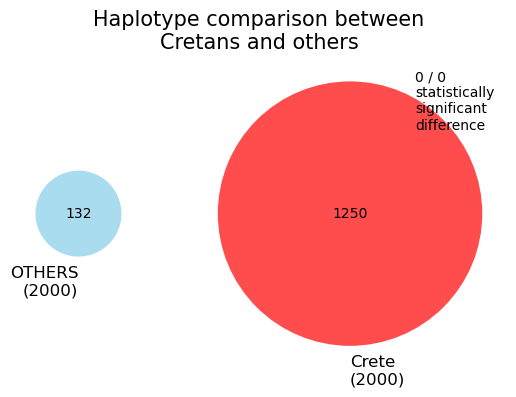

In [270]:
def compare_haplotypes(hfs_dat,         #haplomat output for one population
                       population,      #haplomat output for another population
                       num_Cretans,     #number of samples in one population
                       num_others,      #number of samples in another population
                       no_diagram=None, #returns venn diagramm
                       pvals=None       #returns venn p-values
                      ):
    
    '''
    The statistic comparison bewtween the haplotypes will be estimated with Fisher's exact test,
    due to the small number of counts for the haplotypes. Otherwise, chi_square would be used, 
    like in the allele frequency comparison.
    '''
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.fisher_exact.html
    
    cretan_haplotypes = haplomat_output_parce(hfs_dat, num_Cretans)
    others_haplotypes = haplomat_output_parce(population, num_Cretans)
    common_haplotypes = list(set(cretan_haplotypes.keys()) & set(others_haplotypes.keys()))
    comparison_list_counts = [[x,0,0] for x in common_haplotypes]
    
    for x in comparison_list_counts:
        x[1] += round(cretan_haplotypes[x[0]]*2*num_Cretans)
        x[2] += round(others_haplotypes[x[0]]*2*num_others)    
    
    comparison_list_counts = sorted(comparison_list_counts, key=lambda x:x[1], reverse=True)
    fisher_inputs = [[[2*num_Cretans-x[1], x[1]], [2*num_others-x[2], x[2]]] for x in comparison_list_counts]
    p_values = []
    for x in fisher_inputs:
        oddsratio, pvalue = stats.fisher_exact(x)
        p_values.append(pvalue)
        
    hapl_pval = dict(zip([x[0] for x in comparison_list_counts], p_values))
    
    if pvals:
        return hapl_pval
    
    sig_hapl_pval = {k:v for k,v in hapl_pval.items() if v < 0.05}
   
    if no_diagram:
        print(f'Total Cretan haplotypes: {len(cretan_haplotypes)}')
        print(f"Total others haplotypes: {len(others_haplotypes)}")
        print(f'Common haplotypes: {len(common_haplotypes)}')       
        print(f'Statistcal Significant: {len(sig_hapl_pval)}\n')
        return
    
    white_patch = mpatches.Patch(color='none', label=f'{len(sig_hapl_pval)} / {len(common_haplotypes)}\nstatistically\nsignificant\ndifference')
    leg = plt.legend(handles=[white_patch], loc='upper right', frameon=False)
    leg.set_alpha(0.0)
    
    venn2(subsets = (len(others_haplotypes)-len(common_haplotypes), len(cretan_haplotypes)-len(common_haplotypes),
                     len(common_haplotypes)), set_labels = (f'OTHERS\n({num_others})', f'Crete\n({num_Cretans})'),
                     set_colors=('skyblue', 'red'), alpha = 0.7)
#     venn2(subsets = (len(DKMS_haplotypes)-len(common_haplotypes), len(cretan_haplotypes)-len(common_haplotypes), len(common_haplotypes)), set_labels = (f'DKMS\n({num_DKMS})', f'Crete\n({num_Cretans})'), set_colors=('darkgrey', 'slategrey'), alpha = 0.7)
    plt.title('Haplotype comparison between\nCretans and others', fontsize=15)

#     plt.savefig(f'Vehn with {len(common_haplotypes)} common haplotypes.png', dpi=300)

    plt.show()

# compare_haplotypes(g4_path, hf_DKMS_all_final, 1835, pvals=True)
compare_haplotypes('test_2.dat', 'test.dat', 2000,2000)

In [310]:
def create_pop_excel(cretan_population):
    
    ids = list(cretan_population.keys())
    A1 = [v['A'][0] for k,v in cretan_population.items()]
    A2 = [v['A'][1] for k,v in cretan_population.items()]
    B1 = [v['B'][0] for k,v in cretan_population.items()]
    B2 = [v['B'][1] for k,v in cretan_population.items()]
    C1 = [v['C'][0] for k,v in cretan_population.items()]
    C2 = [v['C'][1] for k,v in cretan_population.items()]
    DRB11 = [v['DRB1'][0] for k,v in cretan_population.items()]
    DRB12 = [v['DRB1'][1] for k,v in cretan_population.items()]
    DQB11 = [v['DQB1'][0] for k,v in cretan_population.items()]
    DQB12 = [v['DQB1'][1] for k,v in cretan_population.items()]
    DPB11 = [v['DPB1'][0] for k,v in cretan_population.items()]
    DPB12 = [v['DPB1'][1] for k,v in cretan_population.items()]
    
    return pd.DataFrame(list(zip(ids,A1,A2,B1,B2,C1,C2,DRB11,DRB12,DQB11,DQB12,DPB11,DPB12)), 
               columns = ['IDs','A*', 'A*.1', 'B*', 'B*.1', 'C*', 'C*.1', 'DRB1*', 'DRB1*.1', 'DQB1*', 'DQB1*.1', 'DPB1*', 'DPB1*.1']) 


create_pop_excel(Lasithi_75).to_excel('Lasithi_75.xlsx', index=False)

In [328]:
### Input preparation for the HW, LD and haplotypic frequency estimation in the Arlequin Software

def arlequin_inputs(txt_file, #txt file derives from create_pop_excel()
                    hla_gene=None, #A or B or C...
                    all_genes=None, #A,B,C,DRB1,DQB1,DPB1
                    include_missing_data=None, #TRUE: if you have missing data
                    num_of_genes=None, #
                    HW=None, #=1 if you want an arlequin input file for Hardy-Weinberg equilibrium
                    LD=None, #=1 if you want an arlequin input file for Linkage Disequillibrium
                    HF=None, #=1 if you want an arlequin input file for Haplotypic Frequencies
                    path=None #just the path of the txt file
                   ):
    
    '''
    txt_file should contain the genotypes with unknown phasing in any resolution of 
    the HLA genes A, B, C, DRB1, DQB1, DPB1 in this order only.
    If there are not data about some of these genes, just put None values on the respective columns.
    In this case set include_missing_data=True.
    
    Your 'path' directory should contain 3 subdirectories: HW/, LD/ and HF/.
    '''
    
    if include_missing_data and txt_file == 'mylopotamos.txt':
        raise Exception('This file has no missing data.')
 
    if hla_gene and all_genes or hla_gene and num_of_genes or num_of_genes and not all_genes:
        raise Exception('You can pick only 1 gene, or all of them, or the first n of them.')
    
    if num_of_genes and not 1<num_of_genes<6 and not isinstance(num_of_genes, int):
        raise Exception("num_of_genes should be an integer from 2 to 5 indicating the first n genes that you wish to be in the input for Arlequin")
    
    if hla_gene and HF or hla_gene and LD:
        raise Exception('You cannot create haplotypes or calculate Linkage Disequillibrium with just 1 genetic loci.')
    
    if HW and LD or HW and HF or LD and HF:
        raise Exception('You can choose only 1 type of analysis for the input preparation.')
    
    with open(txt_file, 'r') as pop:
        pop = pop.readlines()

    pop = [x.strip('\n').split('\t') for x in pop]

    if HF:
        pop = [[x.replace(' ','') for x in y] for y in pop]
    else:
        pop = [[x.replace(' ','').replace(':','') for x in y] for y in pop]
    
    if not include_missing_data:
        pop_tmp = [x for x in pop if sum('' == s for s in x)==0]
    else:
        pop_tmp = pop.copy()
    
    if all_genes:
        pop = [['A'+x[1],
                'A'+x[2],
                'B'+x[3],
                'B'+x[4],
                'C'+x[5],
                'C'+x[6],
                'DR'+x[7],
                'DR'+x[8],
                'DQ'+x[9],
                'DQ'+x[10],
                'DP'+x[11],
                'DP'+x[12]] for x in pop_tmp[1:]]
        
        if num_of_genes:
            pop = [x[:2*num_of_genes] for x in pop]
        
        obs_counts_pop_A = dict(Counter(map(tuple, pop))) 
        obs_counts_pop_A = {k:v for k,v in sorted(obs_counts_pop_A.items(), key = lambda item:item[1], reverse=True)}
        
        if num_of_genes:
            
            if num_of_genes == 2:
                input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\n' for k,v in obs_counts_pop_A.items()]

            if num_of_genes == 3:
                input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\t'+k[4]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\t'+k[5]+'\n' for k,v in obs_counts_pop_A.items()]

            if num_of_genes == 4:
                input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\t'+k[4]+'\t'+k[6]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\t'+k[5]+'\t'+k[7]+'\n' for k,v in obs_counts_pop_A.items()]

            if num_of_genes == 5:
                input_tmp = ['\t'+str(v)+'\t'+k[0]+'\t'+k[2]+'\t'+k[4]+'\t'+k[6]+'\t'+k[8]+'\n'+'\t\t'+k[1]+'\t'+k[3]+'\t'+k[5]+'\t'+k[7]+'\t'+k[9]+'\n' for k,v in obs_counts_pop_A.items()]
        
        else:
            
            input_tmp = ['\t'+str(v)+
                         '\t'+k[0]+
                         '\t'+k[2]+
                         '\t'+k[4]+
                         '\t'+k[6]+
                         '\t'+k[8]+
                         '\t'+k[10]+
                         '\n'+'\t\t'+
                         k[1]+'\t'+
                         k[3]+'\t'+
                         k[5]+'\t'+
                         k[7]+'\t'+
                         k[9]+'\t'+
                         k[11]+'\n' for k,v in obs_counts_pop_A.items()]
            
        input_tmp = [str(input_tmp.index(x)+1)+x for x in input_tmp ]
        
        if include_missing_data:
            input_tmp = [x.replace('\tA\n', '\t?\n').replace('\tB\n', '\t?\n').replace('\tC\n', '\t?\n').replace('\tDR\n', '\t?\n').replace('\tDQ\n', '\t?\n').replace('\tDP\n', '\t?\n').replace('\tA\t', '\t?\t').replace('\tB\t', '\t?\t').replace('\tC\t', '\t?\t').replace('\tDR\t', '\t?\t').replace('\tDQ\t', '\t?\t') for x in input_tmp]       
        
        to_write = ''.join(input_tmp)
        
        
    if not all_genes:
        
        if hla_gene in ('DRB1','DQB1','DPB1'):
            pop = [[hla_gene[0:2]+x.replace(':','') for x in y] for y in pop_tmp]
        else:
            pop = [[hla_gene+x.replace(':','') for x in y] for y in pop_tmp]

        if hla_gene == 'A':
            pop = [x[1:3] for x in pop[1:]]
        elif hla_gene == 'B':
            pop = [x[3:5] for x in pop[1:]]
        elif hla_gene == 'C':
            pop = [x[5:7] for x in pop[1:]]
        elif hla_gene == 'DRB1':
            pop = [x[7:9] for x in pop[1:]]
        elif hla_gene == 'DQB1':
            pop = [x[9:11] for x in pop[1:]]
        elif hla_gene == 'DPB1':
            pop = [x[11:] for x in pop[1:]] 

        pop = sorted(pop, key = lambda x:(x[0],x[1]))

        obs_counts_pop_A = dict(Counter(map(tuple, pop))) 

        input_tmp = ['\t'+str(v)+'\t'+k[0]+'\n'+'\t\t'+k[1]+'\n' for k,v in obs_counts_pop_A.items()]

        input_tmp = [str(input_tmp.index(x)+1)+x for x in input_tmp ]
           
        if include_missing_data:
            input_tmp = [x.replace('\tA\n', '\t?\n').replace('\tB\n', '\t?\n').replace('\tC\n', '\t?\n').replace('\tDR\n', '\t?\n').replace('\tDQ\n', '\t?\n').replace('\tDP\n', '\t?\n') for x in input_tmp]       
        
        to_write = ''.join(input_tmp)  

    print(to_write)
    place = txt_file.split('.')[0]
        
    if HW:
        path = path + 'HW/'
    elif LD:
        path = path + 'LD/'
    elif HF:
        path = path + 'HF/'
    else:
        raise Exception('Something went wrong. Check the HW, LD and HF parameters.')
    
    n1 ='{'
    n2='}'
    
    if all_genes:
        if not num_of_genes:
            n = 6
        else:
            n = num_of_genes
    
    if HW:
        title = f'Hardy-Weinberg equilibrium exact test for {len(pop)} individuals from {place}'
    elif LD:
        title = f'Linkage Disequillibrium test for {n} loci of {len(pop)} individuals from {place}'
    elif HF:
        title = f'Haplotypic Frequencies estimation for {n} loci of {len(pop)} individuals from {place}'
    else:
        raise Exception('Something went wrong. Check the HW, LD and HF parameters.')
    
    final_input = f'''[Profile]

     Title="{title}"
     NbSamples=1
     DataType=STANDARD
     GenotypicData=1
     LocusSeparator=TAB
     GameticPhase=0
     RecessiveData=0
     MissingData="?"

[Data] 

[[Samples]] 

    SampleName="{len(pop)} from {place}"
    SampleSize={len(pop)} # Number of diploid individuals in sample 
    SampleData= {n1}

{to_write}{n2}'''
    
    if include_missing_data:
        md = '_missing_data'
    else:
        md = ''
    
    if all_genes:
        if HW:
            
            if not num_of_genes:
                if os.path.exists(f'{path}{place}_Arlequin_HW_all{md}.arp'):
                    os.remove(f'{path}{place}_Arlequin_HW_all{md}.arp')
                    
                with open(f'{path}{place}_Arlequin_HW_all{md}.arp', 'w') as h:
                    h.write(final_input)
            else:
                
                if os.path.exists(f'{path}{place}_Arlequin_HW_{n}{md}.arp'):
                    os.remove(f'{path}{place}_Arlequin_HW_{n}{md}.arp')

                with open(f'{path}{place}_Arlequin_HW_{n}{md}.arp', 'w') as h:
                    h.write(final_input)
                    
        if LD:
            
            if not num_of_genes:
                if os.path.exists(f'{path}{place}_Arlequin_LD_all{md}.arp'):
                    os.remove(f'{path}{place}_Arlequin_LD_all{md}.arp')

                with open(f'{path}{place}_Arlequin_LD_all{md}.arp', 'w') as h:
                    h.write(final_input)
            else:
                
                if os.path.exists(f'{path}{place}_Arlequin_LD_{n}{md}.arp'):
                    os.remove(f'{path}{place}_Arlequin_LD_{n}{md}.arp')

                with open(f'{path}{place}_Arlequin_LD_{n}{md}.arp', 'w') as h:
                    h.write(final_input)
                    
        if HF:
            
            if os.path.exists(f'{path}{place}_Arlequin_HF_{n}{md}.arp'):
                os.remove(f'{path}{place}_Arlequin_HF_{n}{md}.arp')

            with open(f'{path}{place}_Arlequin_HF_{n}{md}.arp', 'w') as h:
                h.write(final_input)
                    
    if not all_genes:        
        
        if HW:
            
            if os.path.exists(f'{path}{place}_Arlequin_HW_{hla_gene}{md}.arp'):
                os.remove(f'{path}{place}_Arlequin_HW_{hla_gene}{md}.arp')

            with open(f'{path}{place}_Arlequin_HW_{hla_gene}{md}.arp', 'w') as h:
                h.write(final_input)
                
        if LD or HF:
            raise Exception('Something went wrong with the analysis and the number of the genes.')
            
# arlequin_inputs('Crete_75.txt', hla_gene=None, all_genes=True, include_missing_data=False, num_of_genes=None, HW=True, LD=None, HF=None, path = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/')

In [335]:
arlequin_inputs('Lasithi_75.txt',
                hla_gene=None,
                all_genes=True,
                include_missing_data=False,
                num_of_genes=None,
                HW=None,
                LD=1,
                HF=None,
                path = '/Users/vasou/Downloads/')


1	1	A0205	B1402	C0401	DR0102	DQ0302	DP0201
		A2301	B4403	C0802	DR0404	DQ0501	DP0402
2	1	A1101	B5101	C1502	DR0404	DQ0302	DP0401
		A3201	B5108	C1602	DR1301	DQ0603	DP0402
3	1	A0101	B0801	C0602	DR0701	DQ0202	DP0402
		A3001	B1302	C0701	DR0701	DQ0202	DP1001
4	1	A0101	B3701	C0602	DR0404	DQ0202	DP0401
		A0201	B5101	C0702	DR0701	DQ0302	DP0402
5	1	A1101	B3501	C0401	DR0101	DQ0501	DP0401
		A1101	B3501	C0401	DR1454	DQ0503	DP0402



In [ ]:
## KATAFERA NA THN TREXW MONO GIA LD: obtain_pvalue_from_Arlequin_xml
## Mallon de trexw swsta to ARLEQUIN

In [358]:
def obtain_pvalue_from_Arlequin_xml(xml_file, #Arlequin output file
                                    analysis #the type of analysis that you want: LD,HW,HF
                                   ):
    
    '''
    The order of the populations should be Mylopotamos, rest, Crete and the analysis
    should contain 6 HLA genes with the order A, B, C, DRB1, DQB1, DPB1.
    
    The p-values and the haplotypic frequencies cannot be obtained from .xml files 
    that have come from different types of analyses, or from different .ars files 
    or from different parameters in the .arp files or from different types of inputs in 
    general than the ones we used. Our data were genotype data with unknown phasing.
    
    The .xml file must contain only once in its name the expression 
    _{analysis}_{number_of_loci}_ , where {analysis} can either be 'HF','HW' or 'LD'
    and {number_of_loci} can either be 2,3,4,5 or 6. Examples of this  expression: 
    _HF_6_ , _LD_5_ , _HF_4_ .
    '''
    
    if not os.path.exists(xml_file):
        raise Exception('This file does not exist. Chose the correct one from the correct folder.')
    
    if analysis not in ('HW', 'LD', 'HF'):
        raise Exception("analysis can only be 'HW', 'LD' or 'HF'")
    if xml_file.split(f'{analysis}_')[1][0] == 'a':
        n = 6
    else:
        n = int(xml_file.split(f'{analysis}_')[1][0])
    
    with open(xml_file, 'r') as h:
        h = h.readlines()
        
    h = [x.strip('\n') for x in h]              
        
    if analysis == 'HF': 
        
        start = [i for i, x in enumerate(h) if x ==  '    #   Haplotype     Freq.      s.d.']
        end = [i for i, x in enumerate(h) if 'Sum of all' in x]
        
        if len(start) != len(end):
            raise Exception('Something went wrong while parsing the HF.xml file. Could not retrieve the frequencies. Check the .xml file if there is something unusual happening between the populations.')
        
        haplotypes = [h[start[x]+3:end[x]-2] for x in range(len(start))]
        haplotypes = [[y.strip(' ').split(' ') for y in x] for x in haplotypes]
        haplotypes = [[z.split('\t') for y in x for z in y if z] for x in haplotypes]
        
        haplotypes_tmp = []
        
        for x in range(len(haplotypes)):
            haplotypes_tmp.append(list(itertools.chain.from_iterable(haplotypes[x])))
        
        haplotypes = [[haplotypes_tmp[x][y:y+n] for y in list(range(4,len(haplotypes_tmp[x]),n+5))] for x in range(len(haplotypes_tmp))]
        
        hfs = [[haplotypes_tmp[x][y-2] for y in list(range(4,len(haplotypes_tmp[x]),n+5))]  for x in range(len(haplotypes_tmp))]  
         
        for x in range(len(haplotypes)):
            for y in range(len(haplotypes[x])):
                haplotypes[x][y].append(hfs[x][y])
       
        haplotypes = [[['~'.join(haplotypes[x][y][0:n]).replace('A','A*').replace('B','B*').replace('C','C*').replace('DR','DRB1*').replace('DQ','DQB1*').replace('DP','DPB1*'),haplotypes[x][y][n]] for y in list(range(len(haplotypes[x])))] for x in range(len(haplotypes))]
        
        hf_list = []
        
        for x in range(len(haplotypes)):
            hf_dict = {}
            
            for y in list(range(len(haplotypes[x]))):                
                hf_dict[haplotypes[x][y][0]]=float(haplotypes[x][y][1])             
            
            hf_dict = {k: v for k, v in sorted(hf_dict.items(), key=lambda item: item[1], reverse=True)}
            hf_list.append(hf_dict.copy())
        
        return hf_list
    
    elif analysis == 'LD':
        
        combos = len(list(itertools.combinations(list(range(n)), 2)))
        #print(f'combos: {combos}')
        pop_num = len([h[x] for x in range(len(h)) if 'Test of linkage disequilibrium for all pairs of loci:' == h[x] ])
        #print(f'pop_num: {pop_num}')
        h = [h[x+8:x+8+3*combos] for x in range(len(h)) if 'Test of linkage disequilibrium for all pairs of loci:' == h[x]]
        ### the 3 in 3*combos stands for the number of lines in the .xml output LD file and not in the pop_num
        #print(f'h: {h}')
        
        ld_pvals = [[h[x][y],float(re.findall(r'\(P = .*?,', h[x][y+2])[0].split('=  ')[1].strip(','))]
                    for y in list(range(0,3*combos,3)) for x in range(len(h))]
        pops_pvals = []
        
        for x in list(range(pop_num)):
            tmp = []
            
            for y in range(x,len(ld_pvals),pop_num):
                tmp.append(ld_pvals[y][1])
            
            pops_pvals.append(tmp)     
        
        return pops_pvals
    
    elif analysis == 'HW':
        
        pop_num = len([h[x] for x in range(len(h)) if "Locus  #Genot       Obs.Het.     Exp.Het.   P-value     s.d.  Steps done" == h[x] ])
        
        h = [h[x+2:x+2+n] for x in range(len(h)) if "Locus  #Genot       Obs.Het.     Exp.Het.   P-value     s.d.  Steps done" == h[x]]
        h = [[x.strip(' ').split(' ') for x in y] for y in h]
        h = [[z for y in x for z in y if z] for x in h]

        pvals = [float(h[x][y]) for y in list(range(4, 4+7*(n-1)+1, 7)) for x in range(len(h))]
        
        pops_pvals = []
        
        for x in list(range(pop_num)):
            tmp = []
            
            for y in range(x,len(pvals),pop_num):
                tmp.append(pvals[y])
            
            pops_pvals.append(tmp)     
        
        return pops_pvals
    
path = '/Users/vasou/Downloads/phenoHLA.res/'
#DKMS_LD_path = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/LD/Crete_75_Arlequin_LD_all.res/'
#DKMS_HF_path_6 = '/home/manos/Programs/Arlequin/cretan_HLA/DKMS/1835/HF/Crete_75_Arlequin_HF_6.res/'

obtain_pvalue_from_Arlequin_xml(f'{path}phenoHLA_LD_5.xml',#f'{path}phenoHLA_LD_5.xml',
                                'LD'
                               )
# arlequin_DKMS_LD = obtain_pvalue_from_Arlequin_xml(f'{DKMS_LD_path}Crete_75_Arlequin_LD_all.xml', 'LD')
# arlequin_DKMS_HF = obtain_pvalue_from_Arlequin_xml(f'{DKMS_HF_path_6}Crete_75_Arlequin_HF_6.xml','HF')

[[0.0001,
  0.52355,
  0.0173,
  0.25611,
  0.00295,
  0.82025,
  0.06258,
  0.00082,
  0.67002,
  0.15749]]

In [369]:
### Run Arlequin 1000 times and get the mean of HWE p-values of Crete

a = '/Users/vasou/Downloads/LD/'
b = '/Users/vasou/Downloads/WinArl35/arlecore64 HWequil.ars Lasithi_75_Arlequin_LD_all.arp'
c = '/Users/vasou/Downloads/phenoHLA.res/'
#d = 'mv Crete_75_Arlequin_HW_all.xml Crete_75_Arlequin_HW_6.xml'
e = '/Users/vasou/Downloads/phenoHLA.res/phenoHLA_LD_5.xml'

def run_Arlequin_HWE(runs):
        
    pvals = []
    
    for run in range(runs):
        print(run)
        os.chdir(a)
        os.system(b)
        os.chdir(c)
        #os.system(d)
        
        tmp_pvals = obtain_pvalue_from_Arlequin_xml(e, 'LD')
        print(tmp_pvals)
        pvals.append(tmp_pvals[0])
        
    os.chdir('/Users/vasou/Downloads/LD/')
    
    return pvals

def mean_confidence_interval(data, confidence=0.95):    
    
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

arlequin_DKMS_HW = run_Arlequin_HWE(10)

m_Crete_A, ci1_Crete_A, ci2_Crete_A = mean_confidence_interval([x[0] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_B, ci1_Crete_B, ci2_Crete_B = mean_confidence_interval([x[1] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_C, ci1_Crete_C, ci2_Crete_C = mean_confidence_interval([x[2] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_DRB1, ci1_Crete_DRB1, ci2_Crete_DRB1 = mean_confidence_interval([x[3] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_DQB1, ci1_Crete_DQB1, ci2_Crete_DQB1 = mean_confidence_interval([x[4] for x in arlequin_DKMS_HW], confidence=0.95)
m_Crete_DPB1, ci1_Crete_DPB1, ci2_Crete_DPB1 = mean_confidence_interval([x[5] for x in arlequin_DKMS_HW], confidence=0.95)

Crete_HW = [m_Crete_A,m_Crete_B,m_Crete_C,m_Crete_DRB1,m_Crete_DQB1,m_Crete_DPB1]

0
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
1
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
2
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
3
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
4
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
5
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
6
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
7
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
8
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]
9
[[0.0001, 0.52355, 0.0173, 0.25611, 0.00295, 0.82025, 0.06258, 0.00082, 0.67002, 0.15749]]


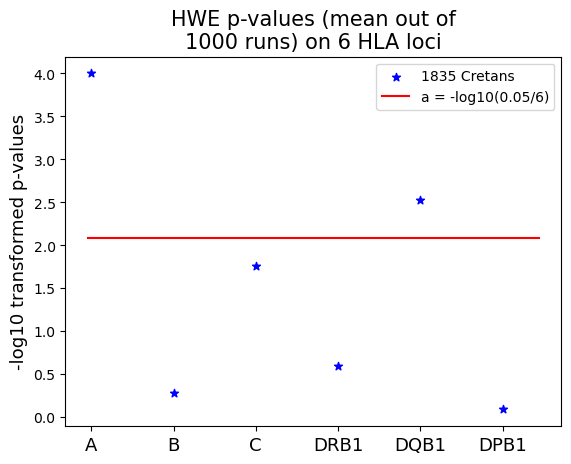

In [371]:
def Arlequin_HWE_pvalues(arlequin_DKMS,log10=None):
    n_cretans = 1835
    if log10:
        
        # We are adding 0.0001 on 0.0 p-values, because log tranformation is not posssible        
        arlequin_DKMS = [-np.log10(x) for x in [0.0001 if x==0 else x for x in arlequin_DKMS]]

    fig, ax = plt.subplots()
    
    plt.scatter(list(range(1,31,5)), arlequin_DKMS, marker='*', color = 'blue',label=f'{n_cretans} Cretans',s=35)
    
    if log10:
        plt.plot([0.8, 28.2],[-np.log10(0.05/6), -np.log10(0.05/6)], color ='red', label='a = -log10(0.05/6)')
        ax.legend()
#         ax.legend(loc='upper left')
        plt.ylabel('-log10 transformed p-values', fontsize = 13)
    else:
        plt.plot([0.8, 28.2],[0.05/6, 0.05/6], color ='red', label='a = 0.05/6')
    ### Corrected threshold: a / (number of genetic loci) where a == 0.05 and (number of genetic loci) == 6
        ax.legend(loc='upper right')
        plt.ylabel('p-values', fontsize = 15)
    
    plt.xticks(list(range(1,31,5)), ['A', 'B', 'C', 'DRB1', 'DQB1', 'DPB1'], fontsize=13) 
    plt.title('HWE p-values (mean out of\n1000 runs) on 6 HLA loci', fontsize=15)       
    
#     fig.tight_layout()
#     fig.set_dpi(300)    
    
#     if log10:
#         plt.savefig("HWE p-values log transformation.png")   
#     else:
#         plt.savefig("HWE p-values.png")   
       
    plt.show()

# Arlequin_HWE_pvalues(Crete_HW)
Arlequin_HWE_pvalues(Crete_HW, log10=True)

In [373]:
def Arlequin_LD_pvalues(arlequin_DKMS,log10=None):
    
    if log10:
        
        # We are adding 0.0001 on 0.0 p-values, because log tranformation is not posssible
        arlequin_DKMS = [-np.log10(x) for x in [0.0001 if x==0 else x for x in arlequin_DKMS]]
    
    fig, ax = plt.subplots()
    
    plt.scatter(list(range(1,76,5)), arlequin_DKMS, marker='*', color = 'blue',label='1835 Cretans',s=35)
    
    if log10:
        plt.plot([0.8, 73.2],[-np.log10(0.05/15), -np.log10(0.05/15)], color ='red', label='a = -log10(0.05/15)')
        plt.ylabel('-log10 transformed p-values', fontsize = 12)
        ax.legend(loc='lower left')
    else:
        plt.plot([0.8, 73.2],[0.05/15, 0.05/15], color ='red', label='a = 0.05/15')
    ### Corrected threshold: a / (number of loci pairs) where a == 0.05 and (number of loci pairs) == 15
        plt.ylabel('p-values', fontsize = 15)    
        ax.legend(loc='upper left')
    
    
    plt.xticks(list(range(1,76,5)), ['A-B','A-C','B-C','A-DRB1','B-DRB1','C-DRB1','A-DQB1','B-DQB1','C-DQB1','DRB1-DQB1','A-DPB1','B-DPB1','C-DPB1','DRB1-DPB1','DQB1-DPB1'], fontsize=10, rotation=-90)
    plt.title("Comparison of LD p-values per loci pair", fontsize=15)       
    
#     fig.tight_layout()    
#     fig.set_dpi(300)
    
#     if log10:
#         plt.savefig("LD p-values log transformation.png")
#     else:
#         plt.savefig("LD p-values.png") 
       
    plt.show()

#arlequin_DKMS_LD = obtain_pvalue_from_Arlequin_xml(f'{DKMS_LD_path}Crete_75_Arlequin_LD_all.xml', 'LD')    

# Arlequin_LD_pvalues(arlequin_DKMS_LD[0],log10=None)
#Arlequin_LD_pvalues(arlequin_DKMS_LD[0],log10=True)